### Import

In [1]:
# Python Bibliotheken
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import os.path

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
import joblib

from tensorflow import keras
from tensorflow.keras import layers
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor 
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
import xgboost as xgb

# Eigene Module
from ../data/dataset_cleaning import dataset_cleaning
from ../data/api_download_dataset_kaggle import api_download_dataset_kaggle

### Laden und Bearbeiten des Datensatzes

Der Dataset wird von Kaggle über eine API heruntergeladen.
Damit die Verbindung funktioniert müssen sie folgenden Schritte erledigen.

- Installation der kaggle-Bibliothek--> pip install kaggle
- Einlogen in Kaggle
- Profil --> Settings --> Create new token --> automatisches Download von "kaggle.json"
- .kaggle Ordner in "C:\Users\" oder "C:\Users\admin" erstellen
- "kaggle.json" in .kaggle einfügen


In [2]:
# Pfad der Rohdaten
raw_dataset_path = 'autoscout24-germany-dataset.csv'

# Wenn die Datei bereits existiert, wird diese nicht nochmal heruntergeladen
if not os.path.exists(raw_dataset_path):
    api_download_dataset_kaggle()

In [3]:
# Bereinigung des Datensets --> Pfad der bereinigten Daten
cleaned_dataset_path = dataset_cleaning(raw_dataset_path)
    

       Kilometerstand   Marke  Model         Kraftstoff Getriebe  Preis  \
194               100    Fiat  Panda           Gasoline   Manual  10600   
197                15    Fiat  Panda  Electric/Gasoline   Manual  10980   
198                15    Fiat  Panda  Electric/Gasoline   Manual  10980   
200                 9  Toyota   Aygo           Gasoline   Manual  11490   
201                 9  Toyota   Aygo           Gasoline   Manual  11490   
...               ...     ...    ...                ...      ...    ...   
46400              99    Fiat    500  Electric/Gasoline   Manual  12990   
46401              99    Fiat    500  Electric/Gasoline   Manual  12990   
46402              99    Fiat    500  Electric/Gasoline   Manual  12990   
46403              99    Fiat    500  Electric/Gasoline   Manual  12990   
46404              99    Fiat    500  Electric/Gasoline   Manual  12990   

       Leistung  Baujahr  
194        69.0     2021  
197        69.0     2021  
198        69.0   

In [4]:
# Laden des Datensatzes
df = pd.read_csv(cleaned_dataset_path)

# Definition von Variablen
brand_col = "Marke"
model_col = "Model"

# Einträge pro Model zählen
model_counts = df.groupby([brand_col, model_col]).size()

# Modelle mit weniger als 50 Einträgen identifizieren
models_to_remove = model_counts[model_counts < 50].index

# Modelle entfernen
for brand, model in models_to_remove:
    df = df.drop(df[(df[brand_col] == brand) & (df[model_col] == model)].index)
    
# Ausgabe des bereinigten Datensatzes
model_counts = df.groupby([brand_col, model_col]).size()

# Daten eines einzigen Kfz-Modells sortieren
df_vw = df[(df["Marke"] == "Volkswagen") & (df["Model"] == "Golf")]

### Trainingsvorbereitung

In [5]:
# Auswählen der Merkmale und der Zielvariablen
features = ['Kilometerstand', 'Leistung', 'Baujahr']
target = 'Preis'

# Aufteilen des Datensatzes in Trainings- und Testdaten
X_train, X_test, y_train, y_test = train_test_split(df_vw[features], df_vw[target], test_size=0.2, random_state=42)

# Skalieren der Merkmale
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Definition von Parametern

In [6]:
# Parameter der Modelle
models = {
    'Lineare Regression': LinearRegression(),
    'Polynomische Regression': make_pipeline(PolynomialFeatures(3), LinearRegression()),
    'Entscheidungsbaumregression': DecisionTreeRegressor(random_state=42),
    'Random Forest Regression': RandomForestRegressor(random_state=42),
    'Gradient Boosting Regression': GradientBoostingRegressor(random_state=42),
    'Deep Learning': keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    layers.Dense(64, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)  # Ausgabeschicht für die Preisvorhersage
])
}

model_param_grid = {
    'Entscheidungsbaumregression': {
                                    'max_depth': [7, 8, 9],
                                    'min_samples_split': [9, 10, 11],
                                    'min_samples_leaf': [1, 2, 3],
                                    'max_features': [2, 3, 4]
                                },
    'Random Forest Regression': {
                                    'n_estimators': [195, 200, 205],
                                    'max_depth': [7, 8, 9],
                                    'min_samples_split': [2, 3, 4],
                                    'min_samples_leaf': [1, 2],
                                    'max_features': ['sqrt']
                                },
    'Gradient Boosting Regression': {
                                    'n_estimators': [95, 96, 97],
                                    'learning_rate': [0.11, 0.12, 0.13],
                                    'max_depth': [1, 2, 3],
                                    'subsample': [0.79, 0.8, 0.81] 
                                }

}


C:\Users\admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


### Trainieren der ML-Modelle

In [7]:
def eb_rfr_gbr(name, model, X_train, X_test, y_train, y_test, model_param_grid):
    # GridSearchCV initialisieren
    grid_search = GridSearchCV(estimator=model, param_grid=model_param_grid[name], cv=3, n_jobs=-1, verbose=0, scoring='r2')
    
    # GridSearchCV trainieren
    model_fit = grid_search.fit(X_train, y_train)
    
    # Beste Hyperparameter ausgeben
    # print("Beste Hyperparameter:", grid_search.best_params_)
    best_params[name] = grid_search.best_params_
    
    # Bestes Modell aus GridSearchCV abrufen
    best_rf_model = grid_search.best_estimator_
    
    # Vorhersagen mit dem besten Modell
    y_pred_test = best_rf_model.predict(X_test)
    y_pred_train = best_rf_model.predict(X_train)
    predictions[name] = y_pred_test

    # R2-Werte ausgeben
    r2_scores_test[name] = r2_score(y_test, y_pred_test)
    r2_scores_train[name] = r2_score(y_train, y_pred_train)
    models_fit[name] = model_fit
    return r2_scores_test, r2_scores_train, predictions, models_fit, best_params

In [8]:
def deep_lr(name, model, X_train, X_test, y_train, y_test, model_param_grid):
    # Kompilieren des Modells
    model.compile(optimizer='adam', loss='mse')
    
    # Trainieren des Modells
    model_fit = model.fit(X_train_scaled, y_train, epochs=100, batch_size=32, verbose=0)
    
    # Vorhersagen auf den Testdaten
    y_pred_test = model.predict(X_test_scaled)
    y_pred_train = model.predict(X_train_scaled)
    predictions[name] = y_pred_test
    
    # Berechnen des R²-Werts
    r2_scores_test[name] = r2_score(y_test, y_pred_test)
    r2_scores_train[name] = r2_score(y_train, y_pred_train)
    models_fit[name] = model_fit
    return r2_scores_test, r2_scores_train, predictions, models_fit, best_params

In [9]:
def lin_pol_regr(name, model, X_train, X_test, y_train, y_test, model_param_grid):
    model_fit = model.fit(X_train, y_train)
    
    # Vorhersagen auf den Testdaten
    y_pred_test = model.predict(X_test)
    y_pred_train = model.predict(X_train)
    predictions[name] = y_pred_test
    
    # Berechnen des Bestimmungsmaßes R^2
    r2_scores_test[name] = r2_score(y_test, y_pred_test)
    r2_scores_train[name] = r2_score(y_train, y_pred_train)
    models_fit[name] = model_fit
    return r2_scores_test, r2_scores_train, predictions, models_fit, best_params

In [10]:
def ml_models(name, model, X_train, X_test, y_train, y_test, model_param_grid):
    if name in ['Entscheidungsbaumregression', 'Random Forest Regression','Gradient Boosting Regression']:
        r2_scores_test, r2_scores_train, predictions, models_fit, best_params = eb_rfr_gbr(name, model, X_train, X_test, y_train, y_test, model_param_grid)

    elif name == 'Deep Learning':
        r2_scores_test, r2_scores_train, predictions, models_fit,best_params = deep_lr(name, model, X_train, X_test, y_train, y_test, model_param_grid)

    else:
        r2_scores_test, r2_scores_train, predictions, models_fit,best_params = lin_pol_regr(name, model, X_train, X_test, y_train, y_test, model_param_grid)
    
    return r2_scores_test, r2_scores_train, predictions, models_fit, best_params

In [11]:
best_param = []
bold_start = "\033[1m"
bold_end = "\033[0m"
best_params = {}
predictions = {}
r2_scores_test = {}
r2_scores_train = {}
models_fit = {}


for name, model in models.items():
    print(name)
    start_time = time.time()
    r2_scores_test, r2_scores_train, _, _, _ = ml_models(name, model, X_train, X_test, y_train, y_test, model_param_grid)
    end_time = time.time()
    execution_time = end_time - start_time
    
    print(f"{bold_start}{name}{bold_end}")
    print(f"R2_test {name}: {r2_scores_test[name]}")
    print(f"R2_train {name}: {r2_scores_train[name]}")
    print(f"Die Ausführungszeit für {name} beträgt {execution_time} Sekunden.")
    print("----------------------------------------------------")
    print("")

Lineare Regression
Lineare Regression
R2_test Lineare Regression: 0.8638171219134214
R2_train Lineare Regression: 0.8789085333707969
Die Ausführungszeit für Lineare Regression beträgt 0.008975744247436523 Sekunden.
----------------------------------------------------

Polynomische Regression
Polynomische Regression
R2_test Polynomische Regression: 0.9069220485289801
R2_train Polynomische Regression: 0.9284459440464532
Die Ausführungszeit für Polynomische Regression beträgt 0.011968135833740234 Sekunden.
----------------------------------------------------

Entscheidungsbaumregression
Entscheidungsbaumregression
R2_test Entscheidungsbaumregression: 0.9238949462843588
R2_train Entscheidungsbaumregression: 0.9511590136625331
Die Ausführungszeit für Entscheidungsbaumregression beträgt 3.8038580417633057 Sekunden.
----------------------------------------------------

Random Forest Regression
Random Forest Regression
R2_test Random Forest Regression: 0.9267149031007669
R2_train Random Forest

### Ermittlung der besten Methode

Im weiteren wird nur die beste Machine Learning Methode eingesetzt. In diesem Fall hat Random Forest Regression am besten abgeschnitten.

In [12]:
# Bestes Modell bestimmen
best_model_name = max(r2_scores_test, key=r2_scores_test.get)
best_model_r2 = r2_scores_test[best_model_name]

# Bestes Modell und R²-Wert ausgeben
print(f"Bestes Modell: {bold_start}{best_model_name}{bold_end}")
print(f"R²-Wert des besten Modells: {bold_start}{best_model_r2}{bold_end}")

Bestes Modell: Random Forest Regression
R²-Wert des besten Modells: 0.9267149031007669


Das sind die Hyperparamtere des besten Modells. Diese wurden durch Finetuning optimiert, dabei wurde die Grid Search Methode verwendet.

In [13]:
_,_,_,_,best_params = ml_models(best_model_name, models[best_model_name], X_train, X_test, y_train, y_test, model_param_grid)
best_params[best_model_name]


{'max_depth': 8,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 4,
 'n_estimators': 195}

### Plotten (Tatsächlicher vs vorhergesagter Preis)

Im Weiteren werden die tatsächlichen und die vorhergesagten Preise abgebildet. Die rote Linie kennzeichnet die ideale Linie. Je näher die Punkte an der Linie liegen, desto besser ist die Vorhersage des Modells.

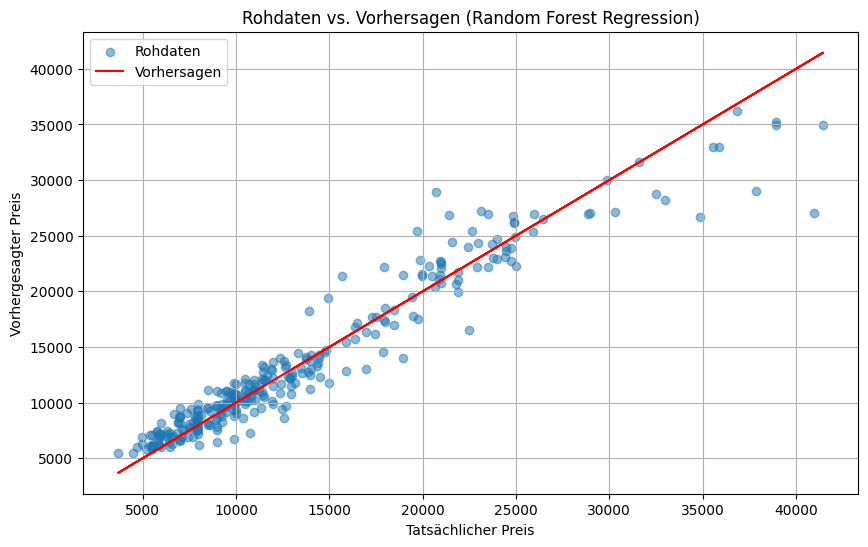

In [14]:
    
# Erstellen der Plots
_, _, predictions, _, _ = ml_models(best_model_name, models[best_model_name], X_train, X_test, y_train, y_test, model_param_grid)
y_pred_test = predictions[best_model_name]

plt.figure(figsize=(10, 6))

# Scatterplot der Rohdaten
plt.scatter(y_test, y_pred_test, alpha=0.5, label='Rohdaten')

# Linienplot der vorhergesagten Daten
plt.plot(y_test, y_test, color='red', label='Vorhersagen')

plt.title(f'Rohdaten vs. Vorhersagen ({best_model_name})')
plt.xlabel('Tatsächlicher Preis')
plt.ylabel('Vorhergesagter Preis')
plt.legend()
plt.grid(True)
plt.show()

### Alle Modelle

Das beste ML-Model wird für jede Marke und Model einzeln berechnet und gespeichert

In [15]:
param = {}
for i in best_params[best_model_name].keys():
    param[i] = [best_params[best_model_name][i]]


Die ML-Modelle für alle Fahrzeuge und KFZ-Modelle werden in einem Ordner abgelegt. Diese werden später bei der Preisberechnung aufgerufen.

In [16]:
model_counts = df.groupby([brand_col, model_col]).size()
# Auswählen der Merkmale und der Zielvariablen
features = ['Kilometerstand', 'Leistung', 'Baujahr']
target = 'Preis'
model_param_grid = {best_model_name : param}

for marke, model_car in model_counts.index:
    df_mm = df[(df["Marke"] == marke) & (df["Model"] == model_car)]
    # Aufteilen des Datensatzes in Trainings- und Testdaten
    X_train, X_test, y_train, y_test = train_test_split(df_mm[features], df_mm[target], test_size=0.2, random_state=42)
    
    R2,_,_,mdlf, best_params = ml_models(best_model_name, models[best_model_name], X_train, X_test, y_train, y_test, model_param_grid)
    
    model_name = "car_price_models/" + marke + '_' + model_car[0:2] + '_ml.joblib'
    

    datei_pfad = "meine_datei.txt"
    
    if os.path.exists(model_name):
        continue
    else:
        joblib.dump(mdlf[best_model_name], model_name)
        
    #print(f"{marke} {model_car} --> R^2: {R2[best_model_name]}")
    #print("")
print("Fertig")

Fertig


### GUI

Mit Hilfe der pyqt5 Bibliothek wird eine GUI erstellt, um die Eingabe und die Berechnung der Preise zu vereinfachen.

In [ ]:
import sys
import os
import pandas as pd
import joblib
from PyQt5.QtWidgets import (QApplication, QWidget, QLabel, QComboBox,
                             QLineEdit, QPushButton, QVBoxLayout, QFormLayout)

class KfzEingabe(QWidget):
    def __init__(self):
        super().__init__()
        self.initUI()

    def initUI(self):
        self.setWindowTitle("KFZ-Preis Prädiktionstool")

        # Dropdown-Listen
        self.marke_label = QLabel("Marke:")
        self.marke_combo = QComboBox()
        self.marke_combo.addItems(marken_liste)

        self.modell_label = QLabel("Modell:")
        self.modell_combo = QComboBox()
        self.modell_combo.addItems(modelle_liste)

        # Eingabefelder
        self.kilometer_label = QLabel("Kilometerstand:")
        self.kilometer_edit = QLineEdit()

        self.leistung_label = QLabel("Leistung (PS):")
        self.leistung_edit = QLineEdit()

        self.baujahr_label = QLabel("Baujahr:")
        self.baujahr_edit = QLineEdit()

        # Button
        self.anzeigen_button = QPushButton("Daten anzeigen und Preis berechnen")
        self.anzeigen_button.clicked.connect(self.daten_anzeigen_und_preis_berechnen)

        # Feld für den berechneten Preis
        self.preis_label = QLabel("Berechneter Preis:")
        self.preis_edit = QLineEdit()
        self.preis_edit.setReadOnly(True)

        # Feld für das geladene Modell
        self.modell_label = QLabel("Modell:")
        self.modell_edit = QLineEdit()
        self.modell_edit.setReadOnly(True)

        # Schließen Button
        self.schliessen_button = QPushButton("Schließen")
        self.schliessen_button.clicked.connect(self.close)

        # Layout
        form_layout = QFormLayout()
        form_layout.addRow(self.marke_label, self.marke_combo)
        form_layout.addRow(self.modell_label, self.modell_combo)
        form_layout.addRow(self.kilometer_label, self.kilometer_edit)
        form_layout.addRow(self.leistung_label, self.leistung_edit)
        form_layout.addRow(self.baujahr_label, self.baujahr_edit)

        main_layout = QVBoxLayout()
        main_layout.addLayout(form_layout)
        main_layout.addWidget(self.anzeigen_button)
        main_layout.addWidget(self.preis_label)
        main_layout.addWidget(self.preis_edit)
        main_layout.addWidget(self.modell_edit)
        main_layout.addWidget(self.schliessen_button)  # Schließen-Button hinzugefügt

        self.setLayout(main_layout)

    def daten_anzeigen_und_preis_berechnen(self):
        marke = self.marke_combo.currentText()
        modell = self.modell_combo.currentText()
        kilometer = self.kilometer_edit.text()
        leistung = self.leistung_edit.text()
        baujahr = self.baujahr_edit.text()

        preis, model_name = self.berechne_preis(marke, modell, kilometer, leistung, baujahr)
        self.preis_edit.setText(str(preis))
        self.modell_edit.setText(str(model_name))

        print("Marke:", marke)
        print("Modell:", modell)
        print("Kilometerstand:", kilometer)
        print("Leistung:", leistung)
        print("Baujahr:", baujahr)
        print("Berechneter Preis:", preis)

    def berechne_preis(self, marke, modell, kilometer, leistung, baujahr):
        model_name = 'car_price_models/' + marke + '_' + modell[0:2] + '_ml.joblib'

        try:
            X_neu = pd.DataFrame([kilometer, leistung, baujahr]).T

            if os.path.isfile(model_name):
                geladenes_modell = joblib.load(model_name)
                preis = geladenes_modell.predict(X_neu)
                print(f"Das eingegebene Fahrzeug kostet: {preis[0]} Euro")
                return preis[0], model_name
            else:
                self.preis_edit.setText("Model Datei nicht gefunden!")
                return 0

        except ValueError:
            self.preis_edit.setText("Fehlerhafte Eingabe!")
            return 0

# Beispiel-Daten für die Dropdown-Listen
multi_index = model_counts.index
marken_liste = multi_index.levels[0].tolist()
modelle_liste = multi_index.levels[1].tolist()

if __name__ == "__main__":
    app = QApplication(sys.argv)
    fenster = KfzEingabe()
    fenster.show()
    sys.exit(app.exec_())

C:\Users\admin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Das eingegebene Fahrzeug kostet: 15638.84713064713 Euro
Marke: BMW
Modell: 530
Kilometerstand: 200000
Leistung: 240
Baujahr: 2013
Berechneter Preis: 15638.84713064713
